In [1]:
# scenario 1: this version has only ACC3=0 .
# (allnodes) surrogate: adj, ACC1:adj, attaque:adj, ACC2: adj^,   Crypto'Graph: adj^, adj2  , ACC3: adj*
# V8.2: Adaptatif budget for each node ACC2=0 + adaptif bud continue till ACC3=0 after defence is 0 :this version ACC2=0 may back to 1 after defence
# and consider ACC1=0 s as  not attacked, because it is already misclassified
# correcting no bud used by-- # remove early stopping  # if not np.any(gradients) : comment out


#  improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)
#
import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
import pandas as pd

# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, modified_edges):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        edge_tuple = tuple(sorted((target_node, i)))
        if edge_tuple in modified_edges:
            continue  # Skip edges that have already been modified

        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append({
            'edge': (target_node, i),
            'action': action,
            'score': score,
            'delta_loss': delta_loss,
            'common_neighbors': common_neighbors
        })
    return scores

# Adaptive attack for a single node
def adaptive_attack_node(adj, adj2, surrogate_model, features, labels, target_node, max_budget, alpha, beta, idx_train, idx_val, dataset):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    budget_used = 0
    misclassified = False
    misclassified_after_defense = False
    attack_stopped_reason = None
    modified_edges = set()  # To prevent re-modification of edges
    budget_used_until_misclassified = None
    budget_used_until_misclassified_after_defense = None
    accuracy_after_CG = 1.0  # Initialize to 1.0 (correctly classified)

    while budget_used < max_budget and not misclassified_after_defense:
        print(f"Current budget used for node {target_node}: {budget_used}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        # Calculate edge scores
        scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta, modified_edges)
        if not scores:
            attack_stopped_reason = 'no_edges_to_modify'
            print(f"No possible edges to modify for node {target_node}. Stopping attack.")
            break

        # Select the edge and action with the highest score
        best_edge_info = max(scores, key=lambda x: x['score'])
        edge = best_edge_info['edge']
        action = best_edge_info['action']
        score = best_edge_info['score']

        # If the score is zero or negative, no beneficial edge modification can be made
        if score <= 0:
            attack_stopped_reason = 'no_positive_score'
            break

        if action == 'add':
            # Perform add
            attacked_adj[edge[0], edge[1]] = 1
            attacked_adj[edge[1], edge[0]] = 1
            added_edges.append(edge)
            print(f"Added edge: {edge}")
        elif action == 'remove':
            # Perform remove
            attacked_adj[edge[0], edge[1]] = 0
            attacked_adj[edge[1], edge[0]] = 0
            removed_edges.append(edge)
            print(f"Removed edge: {edge}")

        # Add the modified edge to the set to prevent re-modification
        edge_tuple = tuple(sorted(edge))
        modified_edges.add(edge_tuple)

        budget_used += 1

        # Check if the node is misclassified after attack
        model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                    nhid=16, device=device, dropout=0.5)
        model = model.to(device)
        model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model.eval()
        output = model.predict(features, attacked_adj)
        pred_label = output.argmax(dim=1)[target_node]
        true_label = labels[target_node]

        node_misclassified = pred_label != true_label

        if not misclassified and node_misclassified:
            # Node is misclassified for the first time after attack
            misclassified = True
            budget_used_until_misclassified = budget_used
            print(f"Node {target_node} misclassified after attack.")

            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            threshold = 2
            metric = "neighbors"
            object = "links"

            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                     nclass=labels.max().item() + 1, device=device)
            # Apply defense
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            is_correct_after_CG = (pred_label_CG[target_node] == labels[target_node]).item()
            accuracy_after_CG = float(is_correct_after_CG)
            print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")

            if accuracy_after_CG == 0.0:
                # Node remains misclassified after defense
                misclassified_after_defense = True
                budget_used_until_misclassified_after_defense = budget_used
                attack_stopped_reason = 'misclassified_after_defense'
                print(f"Node {target_node} misclassified after defense. Attack successful.")
                break
            else:
                # Defense recovered the correct classification
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")
        elif misclassified:
            # Node was misclassified before, check if it remains misclassified after defense
            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            threshold = 2
            metric = "neighbors"
            object = "links"

            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                     nclass=labels.max().item() + 1, device=device)
            # Apply defense
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold, metric=metric, object=object, train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            is_correct_after_CG = (pred_label_CG[target_node] == labels[target_node]).item()
            accuracy_after_CG = float(is_correct_after_CG)
            print(f"Accuracy after Crypto'Graph defense on node {target_node}: {accuracy_after_CG}")

            if accuracy_after_CG == 0.0:
                # Node remains misclassified after defense
                misclassified_after_defense = True
                budget_used_until_misclassified_after_defense = budget_used
                attack_stopped_reason = 'misclassified_after_defense'
                print(f"Node {target_node} misclassified after defense. Attack successful.")
                break
            else:
                # Defense recovered the correct classification
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")

    if not misclassified_after_defense:
        if budget_used >= max_budget:
            attack_stopped_reason = 'budget_exhausted'
            if misclassified:
                attack_stopped_reason = 'misclassified_but_defense_recovered_model_with_available_budget'
                print(f"Budget exhausted. Node {target_node} was misclassified after attack, but defense recovered the correct classification.")
            else:
                attack_stopped_reason = 'budget_exhausted_without_misclassification'
                print(f"Budget exhausted. Node {target_node} was not misclassified.")
        else:
            if misclassified:
                attack_stopped_reason = 'defense_recovered_model'
                print(f"Defense recovered the correct classification for node {target_node}. Attack stopped.")

    # After the attack is finished, compute the number of added edges that were removed by the defense
    num_edges_removed_by_defense = 0
    if misclassified or misclassified_after_defense:
        # Apply the defense one last time to get defended_adj1
        model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16,
                                 nclass=labels.max().item() + 1, device=device)
        _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
            attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
            threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
        # Compute edges removed by defense
        for edge in added_edges:
            if defended_adj1[edge[0], edge[1]] == 0:
                num_edges_removed_by_defense += 1

    return (attacked_adj, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
            attack_stopped_reason, num_edges_removed_by_defense, budget_used_until_misclassified,
            budget_used_until_misclassified_after_defense, accuracy_after_CG)

# Main execution
################################ Data loading #######################################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42

set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

nodes_number = adj.shape[0]
print(f"Number of nodes: {nodes_number}")


# For test nodes
subset_size =  10 # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)
print(f"Subset of idx_test for statistic tests: {subset_idx_test}")

# for all nodes
# subset_idx_test = idx_test  # This will include all nodes in the test set
# print(f"Testing all nodes in idx_test: {len(subset_idx_test)} nodes.")

# Train surrogate model
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Initialize lists for results
node_budgets = []
node_edge_additions = []
node_edge_removals = []
nodes_misclassified = []
nodes_misclassified_after_defense = []
accuracy_before_attack_list = []
accuracy_after_attack_list = []
accuracy_after_CG_list = []
node_ids = []
attack_stopped_reasons = []
node_degrees = []
initial_losses = []
initial_gradient_magnitudes = []
initial_gradients_zero_list = []
edges_removed_by_defense_list = []
budget_used_until_misclassified_list = []
budget_used_until_misclassified_after_defense_list = []
attack_performed_list = []

max_budget_per_node = 10  # Set maximum budget per node
# Parameters for edge score calculation
alpha = 1.0
beta = 1.0

# Iterate over each node in the subset
for node_index, target_node in enumerate(subset_idx_test, start=1):
    print(f"****** Attacking node {node_index}/{len(subset_idx_test)}: {target_node} ******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    # Compute degree of the target node
    degree = adj[target_node].count_nonzero()
    node_degrees.append(degree)

    # Compute initial loss and gradients
    initial_loss, initial_gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    initial_gradient_magnitude = np.linalg.norm(initial_gradients) #the Euclidean norm (2-norm) of the gradient matrix.gives a single scalar value that represents the overall "size" or "strength" of the gradient
    initial_gradients_zero = not np.any(initial_gradients)

    initial_losses.append(initial_loss)
    initial_gradient_magnitudes.append(initial_gradient_magnitude)
    initial_gradients_zero_list.append(int(initial_gradients_zero))

    # Initialize the attacked adjacency matrix for this node
    attacked_adj_node = adj.copy()

    # Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item()+1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    true_label = labels

    # Adjusted calculation for accuracy before attack
    is_correct = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_before_attack = float(is_correct)
    print(f"Accuracy before attack on node {target_node}: {accuracy_before_attack}")

    if accuracy_before_attack == 0:
        print(f"Node {target_node} is already misclassified before attack. Skipping attack.")
        # Record results for this node without performing attack
        node_ids.append(target_node)
        node_budgets.append(0)
        node_edge_additions.append(0)
        node_edge_removals.append(0)
        nodes_misclassified.append(0)  # Attack not performed
        nodes_misclassified_after_defense.append(0)
        accuracy_after_attack_list.append(accuracy_before_attack)
        accuracy_after_CG_list.append(accuracy_before_attack)
        attack_stopped_reasons.append('already_misclassified')
        edges_removed_by_defense_list.append(0)
        budget_used_until_misclassified_list.append(None)
        budget_used_until_misclassified_after_defense_list.append(None)
        attack_performed_list.append(False)
        # Add to lists for completeness
        accuracy_before_attack_list.append(accuracy_before_attack)
        continue  # Skip to next node

    # Attack is applicable; proceed
    attack_performed_list.append(True)

    # Perform adaptive attack on the node
    (attacked_adj_node, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
     attack_stopped_reason, num_edges_removed_by_defense, budget_used_until_misclassified,
     budget_used_until_misclassified_after_defense, accuracy_after_CG) = adaptive_attack_node(
        attacked_adj_node, adj2, surrogate_model, features, labels, target_node, max_budget_per_node, alpha, beta, idx_train, idx_val, dataset)

    attack_stopped_reasons.append(attack_stopped_reason)
    edges_removed_by_defense_list.append(num_edges_removed_by_defense)
    budget_used_until_misclassified_list.append(budget_used_until_misclassified)
    budget_used_until_misclassified_after_defense_list.append(budget_used_until_misclassified_after_defense)

    # Check accuracy after attack
    model.fit(features, attacked_adj_node, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, attacked_adj_node)
    pred_label = output.argmax(dim=1)
    is_correct_after_attack = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_after_attack = float(is_correct_after_attack)
    print(f"Accuracy after attack on node {target_node}: {accuracy_after_attack}")

    # Record results
    node_ids.append(target_node)
    node_budgets.append(budget_used)
    node_edge_additions.append(len(added_edges))
    node_edge_removals.append(len(removed_edges))
    nodes_misclassified.append(int(misclassified))
    nodes_misclassified_after_defense.append(int(misclassified_after_defense))
    accuracy_before_attack_list.append(accuracy_before_attack)
    accuracy_after_attack_list.append(accuracy_after_attack)
    accuracy_after_CG_list.append(accuracy_after_CG)  # Misclassification after defense

    # Print results for the node
    print(f"Node {target_node}:")
    print(f"  Degree: {degree}")
    print(f"  Initial Loss: {initial_loss}")
    print(f"  Initial Gradient Magnitude: {initial_gradient_magnitude}")
    print(f"  Initial Gradients Zero: {initial_gradients_zero}")
    print(f"  Attack Stopped Reason: {attack_stopped_reason}")
    print(f"  Budget Used: {budget_used}")
    print(f"  Budget Used Until Misclassified: {budget_used_until_misclassified}")
    print(f"  Budget Used Until Misclassified After Defense: {budget_used_until_misclassified_after_defense}")
    print(f"  Edges Added: {len(added_edges)}")
    print(f"  Edges Removed: {len(removed_edges)}")
    print(f"  Edges Removed by Defense: {num_edges_removed_by_defense}")
    print(f"  Misclassified After Attack: {bool(misclassified)}")
    print(f"  Misclassified After Defense: {bool(misclassified_after_defense)}")
    print(f"  Accuracy Before Attack: {accuracy_before_attack}")
    print(f"  Accuracy After Attack: {accuracy_after_attack}")
    print(f"  Accuracy After CG Defense: {accuracy_after_CG}")
    print("-" * 50)

# Generate DataFrame with results
results_df = pd.DataFrame({
    'Node': node_ids,
    'Attack Performed': attack_performed_list,
    'Degree': node_degrees,
    'Initial Loss': initial_losses,
    'Initial Gradient Magnitude': initial_gradient_magnitudes,
    'Initial Gradients Zero': initial_gradients_zero_list,
    'Attack Stopped Reason': attack_stopped_reasons,
    'Budget Used': node_budgets,
    'Budget Used Until Misclassified': budget_used_until_misclassified_list,
    'Budget Used Until Misclassified After Defense': budget_used_until_misclassified_after_defense_list,
    'Edges Added': node_edge_additions,
    'Edges Removed': node_edge_removals,
    'Edges Removed by Defense': edges_removed_by_defense_list,
    'Misclassified After Attack': nodes_misclassified,
    'Misclassified After Defense': nodes_misclassified_after_defense,
    'Accuracy Before Attack': accuracy_before_attack_list,
    'Accuracy After Attack': accuracy_after_attack_list,
    'Accuracy After CG Defense': accuracy_after_CG_list
})

# Save the results to a CSV file
results_df.to_csv('attack_results_per_node.csv', index=False)

# Print final summary
print("Final Summary:")
print(results_df)



Loading polblogs dataset...
Number of nodes: 1490
Subset of idx_test for statistic tests: [1214 1367 1480  171  608 1164  870  883   85  552]


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\deeprobust\graph\utils.py:356: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(sparseconcat.t(),sparsedata,torch.Size(sparse_mx.shape))


****** Attacking node 1/10: 1214 ******
Accuracy before attack on node 1214: 1.0
Current budget used for node 1214: 0
Removed edge: (1214, 854)
Current budget used for node 1214: 1
Removed edge: (1214, 1050)
Current budget used for node 1214: 2
Removed edge: (1214, 1100)
Current budget used for node 1214: 3


C:\Users\mahsa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Added edge: (1214, 1111)
Current budget used for node 1214: 4
Removed edge: (1214, 1244)
Current budget used for node 1214: 5
Removed edge: (1214, 1478)
Current budget used for node 1214: 6
Removed edge: (1214, 1152)
Current budget used for node 1214: 7
Removed edge: (1214, 761)
Current budget used for node 1214: 8
Removed edge: (1214, 879)
Current budget used for node 1214: 9
Removed edge: (1214, 1383)
Budget exhausted. Node 1214 was not misclassified.
Accuracy after attack on node 1214: 1.0
Node 1214:
  Degree: 71
  Initial Loss: 0.0
  Initial Gradient Magnitude: 0.0
  Initial Gradients Zero: True
  Attack Stopped Reason: budget_exhausted_without_misclassification
  Budget Used: 10
  Budget Used Until Misclassified: None
  Budget Used Until Misclassified After Defense: None
  Edges Added: 1
  Edges Removed: 9
  Edges Removed by Defense: 0
  Misclassified After Attack: False
  Misclassified After Defense: False
  Accuracy Before Attack: 1.0
  Accuracy After Attack: 1.0
  Accuracy Afte

    Initial Loss        mean        std     variance
0   0.000000e+00  299.580690  76.120965  5794.401284
1   1.192093e-07    2.000000   0.000000     0.000000
2   4.053108e-06    3.000000        NaN          NaN
3   4.649151e-06    1.000000        NaN          NaN
4   5.410551e-03    3.000000        NaN          NaN
5   1.947390e-01    4.000000        NaN          NaN
6   4.420794e-01    2.000000        NaN          NaN
7   1.029176e+00    3.571429   1.027278     1.055300
8   2.181326e+01    1.000000        NaN          NaN
9   4.579236e+01    3.000000        NaN          NaN
10  3.117114e+02    3.000000        NaN          NaN
11  4.001241e+02    4.000000        NaN          NaN
12  5.539114e+02    2.000000        NaN          NaN


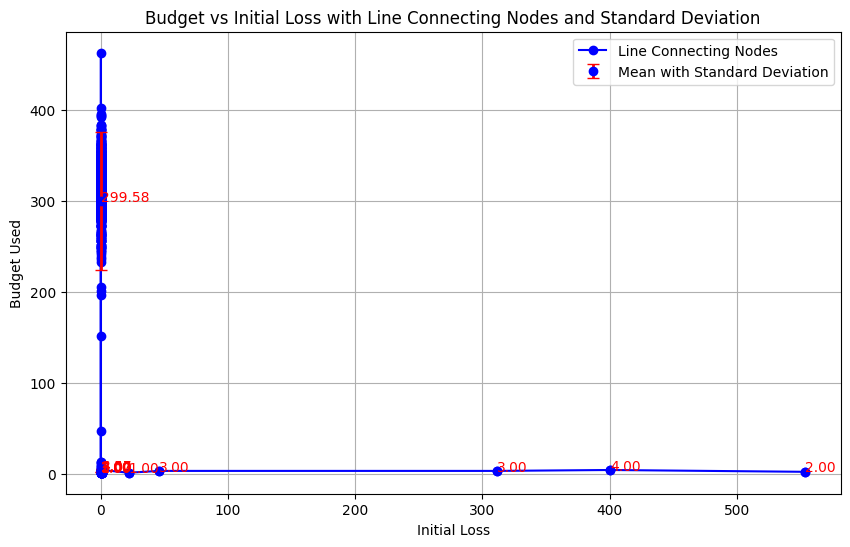

[0.00000000e+00 1.02917576e+00 2.18132629e+01 4.57923584e+01
 1.19209282e-07 5.41055109e-03 5.53911377e+02 4.64915138e-06
 3.11711365e+02 4.05310766e-06 4.00124084e+02 1.94738999e-01
 4.42079365e-01]


In [65]:
# plot the  results for all nodes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
# results_df = pd.read_csv('attack_results_per_node- 50 nodes-V8.2-maxbug500.csv')
results_df = pd.read_csv('attack_results_per_node_950_both_stop.csv')

# Extract relevant columns for the analysis
initial_losses = results_df['Initial Loss'].values
budgets_used = results_df['Budget Used'].values

# Filter the dataset to only include rows where 'Attack Performed' is True
filtered_df = results_df[results_df['Attack Performed'] == True]

# Extract the relevant columns after filtering
filtered_initial_losses = filtered_df['Initial Loss'].values
filtered_budgets_used = filtered_df['Budget Used'].values

# Sort the data based on Initial Loss for proper connection
sorted_indices = np.argsort(filtered_initial_losses)
sorted_initial_losses = filtered_initial_losses[sorted_indices]
sorted_budgets_used = filtered_budgets_used[sorted_indices]

##########################################
# Group by 'Initial Loss' and calculate the mean, std (écart type), and variance of 'Budget Used'
loss_budget_stats = filtered_df.groupby('Initial Loss')['Budget Used'].agg(['mean', 'std']).reset_index()

# Calculate variance (variance = std^2) and add it to the DataFrame
loss_budget_stats['variance'] = loss_budget_stats['std'] ** 2

# Display the statistics
print(loss_budget_stats)

# Plot both the line connecting nodes and standard deviation in red
plt.figure(figsize=(10, 6))

# Plot the line connecting nodes where Attack was Performed
plt.plot(sorted_initial_losses, sorted_budgets_used, marker='o', linestyle='-', color='blue', label='Line Connecting Nodes')

# Plot the error bars for mean and std (showing std in red)
plt.errorbar(loss_budget_stats['Initial Loss'], loss_budget_stats['mean'], yerr=loss_budget_stats['std'], 
             fmt='o', color='blue', ecolor='red', elinewidth=2, capsize=4, label='Mean with Standard Deviation')

# Annotate the plot with mean values for each 'Initial Loss' in red
for i in range(len(loss_budget_stats)):
    plt.text(loss_budget_stats['Initial Loss'][i], loss_budget_stats['mean'][i], 
             f'{loss_budget_stats["mean"][i]:.2f}', color='red', fontsize=10)

# Add titles and labels
plt.title('Budget vs Initial Loss with Line Connecting Nodes and Standard Deviation')
plt.xlabel('Initial Loss')
plt.ylabel('Budget Used')
plt.grid(True)
plt.legend()
plt.show()

##############################################
# Check the unique 'Initial Loss' values in the filtered dataset where attack was performed
unique_initial_losses = filtered_df['Initial Loss'].unique()
print(unique_initial_losses)


    Initial Loss        mean        std     variance
0   0.000000e+00  299.580690  76.120965  5794.401284
1   1.192093e-07    2.000000   0.000000     0.000000
2   4.053108e-06    3.000000        NaN          NaN
3   4.649151e-06    1.000000        NaN          NaN
4   5.410551e-03    3.000000        NaN          NaN
5   1.947390e-01    4.000000        NaN          NaN
6   4.420794e-01    2.000000        NaN          NaN
7   1.029176e+00    3.571429   1.027278     1.055300
8   2.181326e+01    1.000000        NaN          NaN
9   4.579236e+01    3.000000        NaN          NaN
10  3.117114e+02    3.000000        NaN          NaN
11  4.001241e+02    4.000000        NaN          NaN
12  5.539114e+02    2.000000        NaN          NaN
Correlation between Initial Loss and Variance: -0.4998634752221302


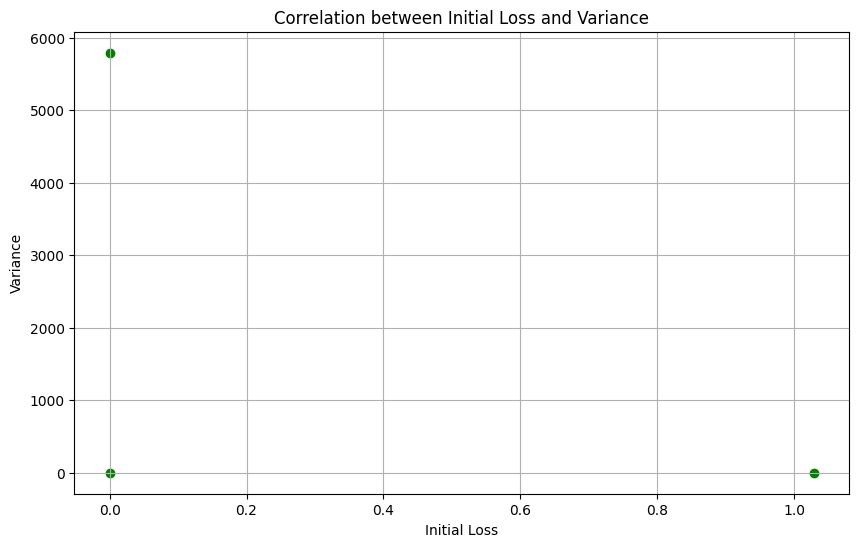

In [66]:
# Correlation between Initial Loss and Variance: 

# Load the dataset
# results_df = pd.read_csv('attack_results_per_node- 50 nodes-V8.2-maxbug500.csv')
results_df = pd.read_csv('attack_results_per_node_950_both_stop.csv')

# Filter the dataset to only include rows where 'Attack Performed' is True
filtered_df = results_df[results_df['Attack Performed'] == True]

# Group by 'Initial Loss' and calculate the mean, std (écart type), and variance of 'Budget Used'
loss_budget_stats = filtered_df.groupby('Initial Loss')['Budget Used'].agg(['mean', 'std']).reset_index()

# Calculate variance (variance = std^2) and add it to the DataFrame
loss_budget_stats['variance'] = loss_budget_stats['std'] ** 2

# Display the statistics
print(loss_budget_stats)

############################################
# Calculate Pearson correlation between 'Initial Loss' and 'variance'
correlation = loss_budget_stats['Initial Loss'].corr(loss_budget_stats['variance'])
print(f"Correlation between Initial Loss and Variance: {correlation}")

# Scatter plot to visualize the relationship between Initial Loss and Variance
plt.figure(figsize=(10, 6))
plt.scatter(loss_budget_stats['Initial Loss'], loss_budget_stats['variance'], color='green')
plt.title('Correlation between Initial Loss and Variance')
plt.xlabel('Initial Loss')
plt.ylabel('Variance')
plt.grid(True)
plt.show()


Correlation between Node Degree and Budget Used: 0.21853108454211284


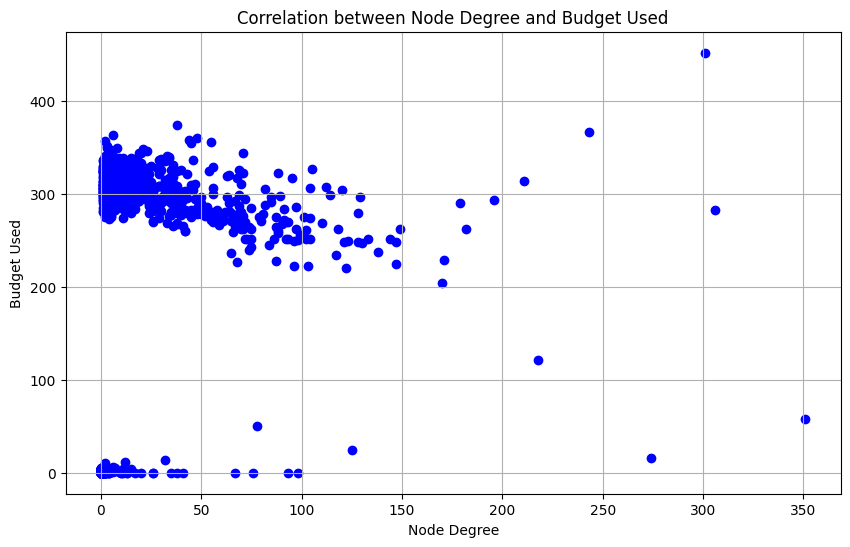

Correlation between Node Degree and Initial Loss: 0.03817285331142017


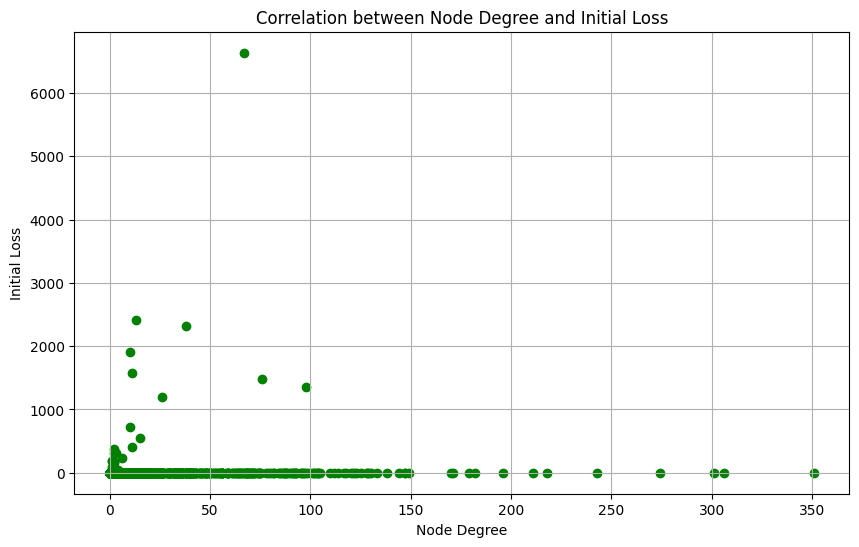

Intercept: 201.35129118935978
Coefficients (Degree, Initial Loss): [ 0.80597292 -0.0785928 ]


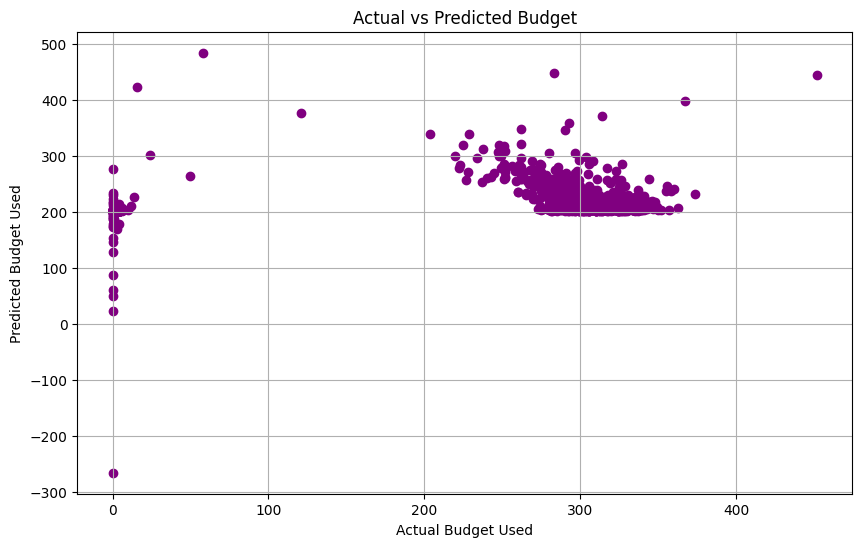

                Degree  Budget Used  Initial Loss
Degree        1.000000     0.259130     -0.084954
Budget Used   0.259130     1.000000     -0.278555
Initial Loss -0.084954    -0.278555      1.000000


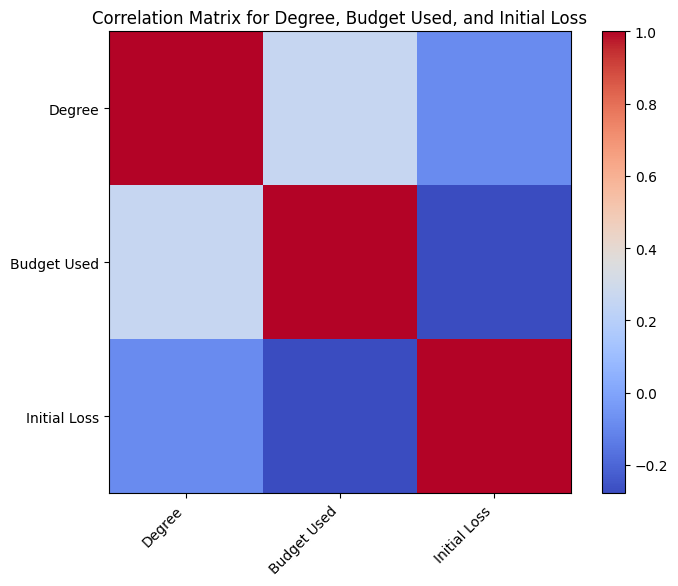

In [15]:
# budget and degree and loss
# Correlation between Degree and Budget Used
correlation_degree_budget = results_df['Degree'].corr(results_df['Budget Used'])
print(f"Correlation between Node Degree and Budget Used: {correlation_degree_budget}")

# Scatter plot to visualize the relationship between Degree and Budget Used
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Degree'], results_df['Budget Used'], color='blue')
plt.title('Correlation between Node Degree and Budget Used')
plt.xlabel('Node Degree')
plt.ylabel('Budget Used')
plt.grid(True)
plt.show()


# Correlation between Degree and Initial Loss
correlation_degree_loss = results_df['Degree'].corr(results_df['Initial Loss'])
print(f"Correlation between Node Degree and Initial Loss: {correlation_degree_loss}")

# Scatter plot to visualize the relationship between Degree and Initial Loss
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Degree'], results_df['Initial Loss'], color='green')
plt.title('Correlation between Node Degree and Initial Loss')
plt.xlabel('Node Degree')
plt.ylabel('Initial Loss')
plt.grid(True)
plt.show()


from sklearn.linear_model import LinearRegression

# Extracting the features (Degree and Initial Loss) and target variable (Budget Used)
X = results_df[['Degree', 'Initial Loss']]
y = results_df['Budget Used']

# Create and fit the linear regression model
reg_model = LinearRegression()
reg_model.fit(X, y)

# Print the coefficients and intercept
print(f"Intercept: {reg_model.intercept_}")
print(f"Coefficients (Degree, Initial Loss): {reg_model.coef_}")

# Predict the budget based on Degree and Initial Loss
predicted_budget = reg_model.predict(X)

# Compare actual and predicted budget
plt.figure(figsize=(10, 6))
plt.scatter(y, predicted_budget, color='purple')
plt.title('Actual vs Predicted Budget')
plt.xlabel('Actual Budget Used')
plt.ylabel('Predicted Budget Used')
plt.grid(True)
plt.show()



# Load the dataset
results_df = pd.read_csv('attack_results_per_node- 50 nodes-V8.2-maxbug500.csv')

# Calculate correlation matrix for Degree, Budget Used, and Initial Loss
correlation_matrix = results_df[['Degree', 'Budget Used', 'Initial Loss']].corr()

# Display the correlation matrix
print(correlation_matrix)

# Create a heatmap using Matplotlib (without seaborn)
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()

# Add labels for the matrix
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha="right")
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Add title
plt.title('Correlation Matrix for Degree, Budget Used, and Initial Loss')

# Show the plot
plt.show()


# # Calculate correlation matrix for Degree, Budget Used, and Initial Loss
# correlation_matrix = results_df[['Degree', 'Budget Used', 'Initial Loss']].corr()
# print(correlation_matrix)

# # Optionally, you can visualize the correlation matrix using a heatmap (requires seaborn library)
# import seaborn as sns
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix for Degree, Budget Used, and Initial Loss')
# plt.show()


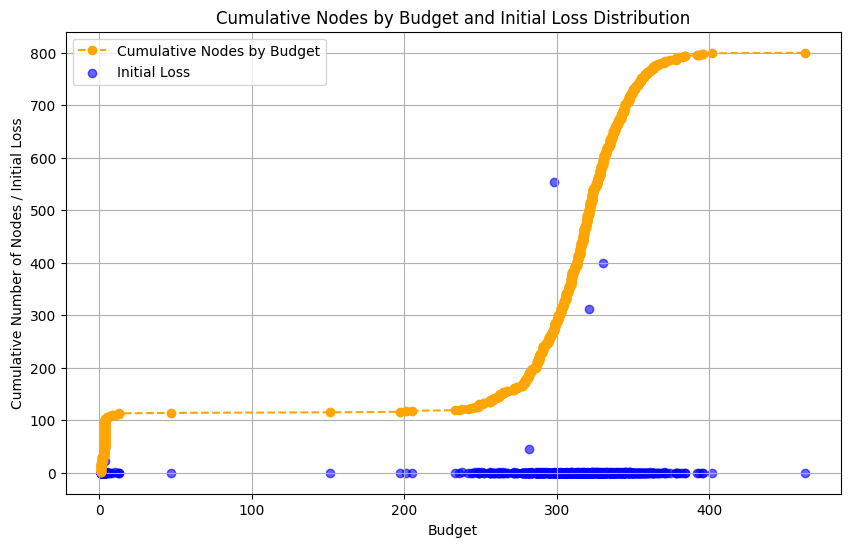

In [67]:
# each budget which loss? 
import matplotlib.pyplot as plt
import pandas as pd

# Load the results CSV file where the data is stored
# Assuming the file is 'attack_results_per_node.csv'
results_df = pd.read_csv('attack_results_per_node_950_both_stop.csv')

# Extract the 'Budget Used Until Misclassified After Defense' column
budgets = results_df['Budget Used Until Misclassified After Defense'].dropna()

# Sort the budgets
sorted_budgets = sorted(budgets)

# Plot cumulative number of nodes versus budget
# plt.figure(figsize=(10, 6))
# plt.plot(sorted_budgets, range(1, len(sorted_budgets) + 1), 'o--', color='orange')

# # Add labels and title
# plt.xlabel('Budget')
# plt.ylabel('Cumulative Number of Nodes')
# plt.title('Cumulative Number of Nodes with Successful Attacks by Budget')

# # Show the plot
# plt.grid(True)
# plt.show()


# Extract initial losses corresponding to the budgets used until misclassified after defense
initial_losses = results_df['Initial Loss'].dropna()

# Assuming budgets and initial_losses are aligned and sorted in the same order
sorted_losses = [initial_losses[i] for i in budgets.index]  # Align the losses with the sorted budgets

# Plot the cumulative number of nodes by budget
plt.figure(figsize=(10, 6))
plt.plot(sorted_budgets, range(1, len(sorted_budgets) + 1), 'o--', color='orange', label='Cumulative Nodes by Budget')

# Overlay a scatter plot of initial losses
plt.scatter(sorted_budgets, sorted_losses, color='blue', label='Initial Loss', alpha=0.6)

# Add labels and title
plt.xlabel('Budget')
plt.ylabel('Cumulative Number of Nodes / Initial Loss')
plt.title('Cumulative Nodes by Budget and Initial Loss Distribution')

# Add a legend to distinguish between the two plots
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


CODE to stop after both ACC2 and ACC3 = 0

In [25]:
# scenario 1: corerct one : changed to check both ACC2 and ACC3 = 0 for stopping the attack , add timer for whole process 
# (allnodes) surrogate: adj, ACC1:adj, attaque:adj, ACC2: adj^,   Crypto'Graph: adj^, adj2  , ACC3: adj*
# V8.2: Adaptatif budget for each node ACC2=0 + adaptif bud continue till ACC3=0 after defence is 0 :this version ACC2=0 may back to 1 after defence
# and consider ACC1=0 s as  not attacked, because it is already misclassified
# correcting no bud used by-- # remove early stopping  # if not np.any(gradients) : comment out

#  improved version 6.1 for exhaustive test on all the nodes   +    with modifications of adding and removing
# without removing negligible zero loss and gradients
# compare accuracy after CG just for adj1 (not average of adj1 and adj2)

import torch
import numpy as np
import torch.nn.functional as F
from deeprobust.graph.defense import GCN
from deeprobust.graph.utils import *
from deeprobust.graph.data import Dataset
from DistributedDefense import TwoPartyCNGCN
from experiments import split_dataset
from scipy.sparse import csr_matrix
import random
import pandas as pd
import time


# Setting seeds for reproducibility
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

# Train surrogate model
def train_surrogate_model(features, adj, labels, idx_train, idx_val):
    surrogate_model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
    surrogate_model = surrogate_model.to(device)
    surrogate_model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    return surrogate_model

# Compute gradients of loss w.r.t adjacency matrix
def compute_gradients(surrogate_model, features, adj, labels, target_node):
    surrogate_model.eval()
    adj = torch.FloatTensor(adj.toarray()).to(device)
    adj.requires_grad = True
    features = torch.FloatTensor(features.toarray()).to(device)
    labels = torch.LongTensor(labels).to(device)
    output = surrogate_model(features, adj)
    loss = F.nll_loss(output[[target_node]], labels[[target_node]])
    loss.backward()
    gradients = adj.grad.cpu().numpy()
    return loss.item(), gradients

# Calculate common neighbors between two nodes
def calculate_common_neighbors(adj, node1, node2):
    neighbors1 = set(adj[node1].indices)
    neighbors2 = set(adj[node2].indices)
    common_neighbors = neighbors1 & neighbors2
    return len(common_neighbors)

# Calculate edge scores for all possible actions
def calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, modified_edges):
    scores = []
    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        edge_tuple = tuple(sorted((target_node, i)))
        if edge_tuple in modified_edges:
            continue  # Skip edges that have already been modified

        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue
        scores.append({
            'edge': (target_node, i),
            'action': action,
            'score': score,
            'delta_loss': delta_loss,
            'common_neighbors': common_neighbors
        })
    return scores

# Adaptive attack for a single node
def adaptive_attack_node(adj, adj2, surrogate_model, features, labels, target_node, max_budget, alpha, beta, idx_train, idx_val, dataset):
    attacked_adj = adj.copy()
    added_edges = []
    removed_edges = []
    budget_used = 0
    misclassified = False
    misclassified_after_defense = False
    attack_stopped_reason = None
    modified_edges = set()  # To prevent re-modification of edges
    budget_used_until_misclassified = None
    budget_used_until_misclassified_after_defense = None
    accuracy_after_attack = 1.0  # Initialize to 1.0 (assumed correct initially)

    while budget_used < max_budget:
        print(f"Current budget used for node {target_node}: {budget_used}")
        loss, gradients = compute_gradients(surrogate_model, features, attacked_adj, labels, target_node)

        # Calculate edge scores
        scores = calculate_edge_scores_all_actions(attacked_adj, gradients, target_node, labels, alpha, beta, modified_edges)
        if not scores:
            attack_stopped_reason = 'no_edges_to_modify'
            print(f"No possible edges to modify for node {target_node}. Stopping attack.")
            break

        # Select the edge and action with the highest score
        best_edge_info = max(scores, key=lambda x: x['score'])
        edge = best_edge_info['edge']
        action = best_edge_info['action']
        score = best_edge_info['score']

        # If the score is zero or negative, no beneficial edge modification can be made
        if score <= 0:
            attack_stopped_reason = 'no_positive_score'
            break

        if action == 'add':
            # Perform add
            attacked_adj[edge[0], edge[1]] = 1
            attacked_adj[edge[1], edge[0]] = 1
            added_edges.append(edge)
            print(f"Added edge: {edge}")
        elif action == 'remove':
            # Perform remove
            attacked_adj[edge[0], edge[1]] = 0
            attacked_adj[edge[1], edge[0]] = 0
            removed_edges.append(edge)
            print(f"Removed edge: {edge}")

        # Add the modified edge to the set to prevent re-modification
        edge_tuple = tuple(sorted(edge))
        modified_edges.add(edge_tuple)

        budget_used += 1

        # Check if the node is misclassified after attack
        model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1, nhid=16, device=device, dropout=0.5)
        model = model.to(device)
        model.fit(features, attacked_adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
        model.eval()
        output = model.predict(features, attacked_adj)
        pred_label = output.argmax(dim=1)[target_node]
        true_label = labels[target_node]

        misclassified = pred_label != true_label
        accuracy_after_attack = float(not misclassified)  # Store accuracy after attack

        if misclassified:
            # Apply Crypto'Graph defense
            print("Applying Crypto'Graph defense...")
            model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
            _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
                attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
                threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
            model_CG.eval()

            # Evaluate after CG defense
            output_CG = model_CG.gcn1.predict(features, defended_adj1)
            pred_label_CG = output_CG.argmax(dim=1)
            misclassified_after_defense = (pred_label_CG[target_node] != labels[target_node]).item()

            if misclassified and misclassified_after_defense:
                print(f"Node {target_node} misclassified after both attack and defense. Attack successful.")
                attack_stopped_reason = 'simultaneous_misclassification'
                budget_used_until_misclassified_after_defense = budget_used
                break
            elif not misclassified_after_defense:
                # If defense recovers the classification, continue attacking
                print(f"Defense recovered the correct classification for node {target_node}. Continuing attack.")

    if not misclassified_after_defense:
        if budget_used >= max_budget:
            attack_stopped_reason = 'budget_exhausted'
            if misclassified:
                attack_stopped_reason = 'misclassified_but_defense_recovered_model_with_available_budget'
                print(f"Budget exhausted. Node {target_node} was misclassified after attack, but defense recovered the correct classification.")
            else:
                attack_stopped_reason = 'budget_exhausted_without_misclassification'
                print(f"Budget exhausted. Node {target_node} was not misclassified.")
        else:
            if misclassified:
                attack_stopped_reason = 'defense_recovered_model'
                print(f"Defense recovered the correct classification for node {target_node}. Attack stopped.")

    # After the attack is finished, compute the number of added edges that were removed by the defense
    num_edges_removed_by_defense = 0
    if misclassified or misclassified_after_defense:
        # Apply the defense one last time to get defended_adj1
        model_CG = TwoPartyCNGCN(dataset=dataset, nfeat=features.shape[1], nhid=16, nclass=labels.max().item() + 1, device=device)
        _, _, _, _, defended_adj1, defended_adj2 = model_CG.fit(
            attacked_adj.copy(), adj2.copy(), features, features, labels, idx_train,
            threshold=2, metric="neighbors", object="links", train_iters=200, initialize=True, verbose=False, idx_val=idx_val)
        # Compute edges removed by defense
        for edge in added_edges:
            if defended_adj1[edge[0], edge[1]] == 0:
                num_edges_removed_by_defense += 1

    return (attacked_adj, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
            attack_stopped_reason, budget_used_until_misclassified, budget_used_until_misclassified_after_defense, accuracy_after_attack, num_edges_removed_by_defense)

# Main execution
################################ Data loading #######################################
start_time = time.time()  # Start the timer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
dataset = "polblogs"
data = Dataset(root='.', name=dataset, setting='gcn', seed=15)
seed = 42

set_seeds(seed)
adj, features, labels = data.adj, data.features, data.labels
idx_train, idx_val, idx_test = data.idx_train, data.idx_val, data.idx_test

proportion_of_common_links = 0.5
adj1, adj2 = split_dataset(adj, proportion_of_common_links) 

nodes_number = adj.shape[0]
print(f"Number of nodes: {nodes_number}")

# For test nodes
subset_size =  1 # Number of nodes to reduce idx_test for performing statistic tests 
subset_idx_test = np.random.choice(idx_test, subset_size, replace=False)
print(f"Subset of idx_test for statistic tests: {subset_idx_test}")

# Train surrogate model
surrogate_model = train_surrogate_model(features, adj, labels, idx_train, idx_val)

# Initialize lists for results
node_budgets = []
node_edge_additions = []
node_edge_removals = []
nodes_misclassified = []
nodes_misclassified_after_defense = []
accuracy_before_attack_list = []
accuracy_after_attack_list = []
accuracy_after_CG_list = []
node_ids = []
attack_stopped_reasons = []
node_degrees = []
initial_losses = []
initial_gradient_magnitudes = []
initial_gradients_zero_list = []
budget_used_until_misclassified_list = []
budget_used_until_misclassified_after_defense_list = []
attack_performed_list = []
edges_removed_by_defense_list = []

max_budget_per_node = 500  # Set maximum budget per node
# Parameters for edge score calculation
alpha = 1.0
beta = 1.0

# Iterate over each node in the subset
for node_index, target_node in enumerate(subset_idx_test, start=1):
    print(f"****** Attacking node {node_index}/{len(subset_idx_test)}: {target_node} ******")
    idx_test_attack = [target_node]
    idx_test_clean = [node for node in idx_test if node != target_node]

    # Compute degree of the target node
    degree = adj[target_node].count_nonzero()
    node_degrees.append(degree)

    # Compute initial loss and gradients
    initial_loss, initial_gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    initial_gradient_magnitude = np.linalg.norm(initial_gradients)
    initial_gradients_zero = not np.any(initial_gradients)

    initial_losses.append(initial_loss)
    initial_gradient_magnitudes.append(initial_gradient_magnitude)
    initial_gradients_zero_list.append(int(initial_gradients_zero))

    # Train GCN model initially for evaluation before attack
    model = GCN(nfeat=features.shape[1], nclass=labels.max().item() + 1,
                nhid=16, device=device, dropout=0.5)
    model = model.to(device)
    model.fit(features, adj, labels, idx_train, idx_val=idx_val, patience=30, train_iters=200)
    model.eval()
    output = model.predict(features, adj)
    pred_label = output.argmax(dim=1)
    true_label = labels

    # Calculate accuracy before attack
    is_correct = (pred_label[target_node] == true_label[target_node]).item()
    accuracy_before_attack = float(is_correct)
    print(f"Accuracy before attack on node {target_node}: {accuracy_before_attack}")

    if accuracy_before_attack == 0:
        print(f"Node {target_node} is already misclassified before attack. Skipping attack.")
        # Record results for this node without performing attack
        node_ids.append(target_node)
        node_budgets.append(0)
        node_edge_additions.append(0)
        node_edge_removals.append(0)
        nodes_misclassified.append(0)  # Attack not performed
        nodes_misclassified_after_defense.append(0)
        accuracy_after_attack_list.append(accuracy_before_attack)
        accuracy_after_CG_list.append(accuracy_before_attack)
        attack_stopped_reasons.append('already_misclassified')
        budget_used_until_misclassified_list.append(None)
        budget_used_until_misclassified_after_defense_list.append(None)
        attack_performed_list.append(False)
        edges_removed_by_defense_list.append(0)
        accuracy_before_attack_list.append(accuracy_before_attack)
        continue  # Skip to next node

    # Attack is applicable; proceed
    attack_performed_list.append(True)

    # Perform adaptive attack on the node
    (attacked_adj_node, budget_used, added_edges, removed_edges, misclassified, misclassified_after_defense,
     attack_stopped_reason, budget_used_until_misclassified, budget_used_until_misclassified_after_defense, accuracy_after_attack, num_edges_removed_by_defense) = adaptive_attack_node(
        adj, adj2, surrogate_model, features, labels, target_node, max_budget_per_node, alpha, beta, idx_train, idx_val, dataset)

    attack_stopped_reasons.append(attack_stopped_reason)
    budget_used_until_misclassified_list.append(budget_used_until_misclassified)
    budget_used_until_misclassified_after_defense_list.append(budget_used_until_misclassified_after_defense)
    edges_removed_by_defense_list.append(num_edges_removed_by_defense)

    # Record results
    node_ids.append(target_node)
    node_budgets.append(budget_used)
    node_edge_additions.append(len(added_edges))
    node_edge_removals.append(len(removed_edges))
    nodes_misclassified.append(int(misclassified))
    nodes_misclassified_after_defense.append(int(misclassified_after_defense))
    accuracy_before_attack_list.append(accuracy_before_attack)
    accuracy_after_attack_list.append(accuracy_after_attack)
    accuracy_after_CG_list.append(float(not misclassified_after_defense))

    # Print results for the node
    print(f"Node {target_node}:")
    print(f"  Degree: {degree}")
    print(f"  Initial Loss: {initial_loss}")
    print(f"  Initial Gradient Magnitude: {initial_gradient_magnitude}")
    print(f"  Initial Gradients Zero: {initial_gradients_zero}")
    print(f"  Attack Stopped Reason: {attack_stopped_reason}")
    print(f"  Budget Used: {budget_used}")
    print(f"  Budget Used Until Misclassified: {budget_used_until_misclassified}")
    print(f"  Budget Used Until Misclassified After Defense: {budget_used_until_misclassified_after_defense}")
    print(f"  Edges Added: {len(added_edges)}")
    print(f"  Edges Removed: {len(removed_edges)}")
    print(f"  Edges Removed by Defense: {num_edges_removed_by_defense}")
    print(f"  Misclassified After Attack: {bool(misclassified)}")
    print(f"  Misclassified After Defense: {bool(misclassified_after_defense)}")
    print(f"  Accuracy Before Attack: {accuracy_before_attack}")
    print(f"  Accuracy After Attack: {accuracy_after_attack}")
    print(f"  Accuracy After CG Defense: {float(not misclassified_after_defense)}")
    print("-" * 50)

# Generate DataFrame with results
results_df = pd.DataFrame({
    'Node': node_ids,
    'Attack Performed': attack_performed_list,
    'Degree': node_degrees,
    'Initial Loss': initial_losses,
    'Initial Gradient Magnitude': initial_gradient_magnitudes,
    'Initial Gradients Zero': initial_gradients_zero_list,
    'Attack Stopped Reason': attack_stopped_reasons,
    'Budget Used': node_budgets,
    'Budget Used Until Misclassified': budget_used_until_misclassified_list,
    'Budget Used Until Misclassified After Defense': budget_used_until_misclassified_after_defense_list,
    'Edges Added': node_edge_additions,
    'Edges Removed': node_edge_removals,
    'Edges Removed by Defense': edges_removed_by_defense_list,
    'Misclassified After Attack': nodes_misclassified,
    'Misclassified After Defense': nodes_misclassified_after_defense,
    'Accuracy Before Attack': accuracy_before_attack_list,
    'Accuracy After Attack': accuracy_after_attack_list,
    'Accuracy After CG Defense': accuracy_after_CG_list
})

# Save the results to a CSV file
results_df.to_csv('attack_results_per_node.csv', index=False)

# Print final summary
print("Final Summary:")
print(results_df)


# Print total execution time
end_time = time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time:.2f} seconds")

Loading polblogs dataset...
Number of nodes: 1490
Subset of idx_test for statistic tests: [1214]
****** Attacking node 1/1: 1214 ******
Accuracy before attack on node 1214: 1.0
Current budget used for node 1214: 0
Removed edge: (1214, 854)
Current budget used for node 1214: 1
Removed edge: (1214, 1050)
Current budget used for node 1214: 2
Removed edge: (1214, 1100)
Current budget used for node 1214: 3
Added edge: (1214, 1111)
Current budget used for node 1214: 4
Removed edge: (1214, 1244)
Current budget used for node 1214: 5
Removed edge: (1214, 1478)
Current budget used for node 1214: 6
Removed edge: (1214, 1152)
Current budget used for node 1214: 7
Removed edge: (1214, 761)
Current budget used for node 1214: 8
Removed edge: (1214, 879)
Current budget used for node 1214: 9
Removed edge: (1214, 1383)
Current budget used for node 1214: 10
Added edge: (1214, 1208)
Current budget used for node 1214: 11
Removed edge: (1214, 1040)
Current budget used for node 1214: 12
Removed edge: (1214, 1

In [58]:
#check for each node situation based on attack result have been done

# Analyze the attack process for a specific node (1318 in this case)
target_node = 1059
k = 1  # Set the value of k to the number of top decisions you want to see

# Step 1: Get the degree of the target node
degree = adj[target_node].count_nonzero()
print(f"Degree of node {target_node}: {degree}")

# Step 2: Compute the initial loss and gradients for the node
initial_loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
print(f"Initial loss for node {target_node}: {initial_loss}")
print(f"Initial gradients for node {target_node}: {gradients[target_node]}")

# Step 3: Calculate edge scores based on gradients and common neighbors for node 1318
alpha = 1.0  # Alpha parameter for gradient impact
beta = 1.0  # Beta parameter for common neighbors impact

# Calculate edge scores for all possible actions
scores = calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, set())

# Sort scores to identify the best k actions
if scores:
    # Sort by score in descending order
    sorted_scores = sorted(scores, key=lambda x: x['score'], reverse=True)

    # Get the top k scores (best edge actions)
    top_k_scores = sorted_scores[:k]

    # Step 4: Output the details of the top k edge actions along with the real labels
    print(f"Top {k} edge modifications for node {target_node}:")
    print(f"Target node {target_node} - Real label: {labels[target_node].item()}")

    for idx, edge_info in enumerate(top_k_scores, 1):
        edge = edge_info['edge']
        action = edge_info['action']
        score = edge_info['score']
        common_neighbors = edge_info['common_neighbors']
        delta_loss = edge_info['delta_loss']

        # Get the other node involved in the edge
        other_node = edge[1] if edge[0] == target_node else edge[0]

        # Print real label of the other node
        print(f"  {idx}. {action.capitalize()} edge {edge} - Score: {score}, Delta Loss: {delta_loss}, Common Neighbors: {common_neighbors}")
        print(f"     Node {edge[0]} - Real label: {labels[edge[0]].item()}")
        print(f"     Node {edge[1]} - Real label: {labels[edge[1]].item()}")

else:
    print(f"No possible edge modifications for node {target_node}")

# Extra functions to inspect the neighbors of the target node (1318)
def get_neighbors(adj, node):
    neighbors = set(adj[node].indices)
    return neighbors

# Step 5: Print the neighbors of node 1318 and the selected edge for the top action
if scores:
    top_edge = top_k_scores[0]['edge']  # Get the best edge for example
    other_node = top_edge[1] if top_edge[0] == target_node else top_edge[0]
    neighbors_1318 = get_neighbors(adj, target_node)
    neighbors_other_node = get_neighbors(adj, other_node)
    common_neighbors = neighbors_1318 & neighbors_other_node
    print(f"Neighbors of node {target_node}: {neighbors_1318}")
    print(f"Common neighbors between node {target_node} and node {other_node}: {common_neighbors}")


Degree of node 1059: 3
Initial loss for node 1059: 0.0
Initial gradients for node 1059: [ 1.8960700e-08  3.1667799e-08 -5.3847227e-10 ... -2.3603570e-09
 -1.8049052e-08 -2.2928388e-09]
Top 1 edge modifications for node 1059:
Target node 1059 - Real label: 1
  1. Add edge (1059, 821) - Score: 1.9999999830896353, Delta Loss: -1.691036466411333e-08, Common Neighbors: 2
     Node 1059 - Real label: 1
     Node 821 - Real label: 1
Neighbors of node 1059: {899, 949, 590}
Common neighbors between node 1059 and node 821: {899, 949}


In [71]:
# check for A FILE OF NODES situation based on imported csv file. attack must have been done before

# Function to get neighbors of a node
def get_neighbors(adj, node):
    neighbors = set(adj[node].indices)
    return neighbors

# Function to process each node and return all required results
def process_node(target_node, k, adj, features, labels, surrogate_model, alpha=1.0, beta=1.0):
    # Calculate degree
    degree = adj[target_node].count_nonzero()
    
    # Compute initial loss and gradients for the node
    initial_loss, gradients = compute_gradients(surrogate_model, features, adj, labels, target_node)
    
    # Calculate edge scores based on gradients and common neighbors for the node
    scores = calculate_edge_scores_all_actions(adj, gradients, target_node, labels, alpha, beta, set())
    
    # Sort scores to get the top k best edge modifications
    sorted_scores = sorted(scores, key=lambda x: x['score'], reverse=True)[:k]

    # Prepare the result dictionary
    result = {
        'Node': target_node,
        'Degree': degree,
        'Initial Loss': initial_loss,
        # 'Initial Gradients': gradients[target_node].tolist(),  # Convert gradients to list
        'Real Label': labels[target_node].item(),
        'budget or k': k,
        'Neighbors': list(get_neighbors(adj, target_node)), 
        'Top K Edge Modifications': []
    }

    # Process each top k edge modification
    for edge_info in sorted_scores:
        edge = edge_info['edge']
        action = edge_info['action']
        score = edge_info['score']
        delta_loss = edge_info['delta_loss']
        common_neighbors = edge_info['common_neighbors']
        
        # Identify the other node in the edge
        other_node = edge[1] if edge[0] == target_node else edge[0]
        other_node_degree = adj[other_node].count_nonzero()
        other_node_real_label = labels[other_node].item()
        other_node_neighbors = get_neighbors(adj, other_node)
        
        # Common neighbors between target node and other node
        common_neighbors_set = get_neighbors(adj, target_node) & other_node_neighbors
        
        # Add edge modification details to the result
        result['Top K Edge Modifications'].append({
            'Edge': edge,
            'Action': action,
            'Score': score,
            'Delta Loss': delta_loss,
            'Common Neighbors': common_neighbors,
            'Selected Node Degree': other_node_degree,
            'Selected Node Real Label': other_node_real_label,
            'Common Neighbors List': list(common_neighbors_set)
        })

    return result

# Load CSV with node IDs and K values : k is budget used until misclassified after defense
# input_file = 'nodes_k.csv'  # Replace with  input file path
input_file = 'nodes_anormals.csv'
node_k_df = pd.read_csv(input_file)

# Prepare an empty list to store the results
results = []

# Loop through each node and its corresponding k value
for index, row in node_k_df.iterrows():
    target_node = row['Node']
    k = row['Budget Used']
    
    # Process the node and store the results
    result = process_node(target_node, k, adj, features, labels, surrogate_model)
    results.append(result)

# Convert results to a DataFrame
output_df = pd.DataFrame(results)

# Export the results to a CSV file
output_file = 'output_node_analysis.csv'  
output_df.to_csv(output_file, index=False)

print("Results saved to:", output_file)


Results saved to: output_node_analysis.csv


In [61]:
# Read the CSV file
output_df = pd.read_csv(output_file)

# Print the contents of the CSV file
# print(output_df.head())
print(output_df)




    Node  Degree  Initial Loss  \
0   1318       3  0.000000e+00   
1    236       2  0.000000e+00   
2    911       1  0.000000e+00   
3    344       9  0.000000e+00   
4   1354       3  0.000000e+00   
5   1078       1  0.000000e+00   
6    910       5  0.000000e+00   
7   1168       2  0.000000e+00   
8   1439       2  0.000000e+00   
9    128       1  0.000000e+00   
10  1301       2  0.000000e+00   
11  1202       4  0.000000e+00   
12   704       1  0.000000e+00   
13   351       4  0.000000e+00   
14  1017       1  0.000000e+00   
15  1480       1  0.000000e+00   
16   889       1  0.000000e+00   
17   268       1  0.000000e+00   
18  1404       1  0.000000e+00   
19  1288       1  2.144302e-01   
20   930       2  0.000000e+00   
21  1139      15  3.514553e+01   
22   883       1  0.000000e+00   
23  1013       1  0.000000e+00   
24   506       3  0.000000e+00   
25   689       1  0.000000e+00   
26   833       1  0.000000e+00   
27  1179       7  0.000000e+00   
28   798      

In [ ]:
#### changing edge score calculation---- for identical scores: when loss=0 and common neighbors of many nodes are the same
# 2 step pioiritise also to consider the balance between same and different labels
# merge with main code 


def calculate_edge_scores_balanced(adj, gradients, target_node, labels, alpha, beta, modified_edges):
    target_label = labels[target_node].item()  # Get the label of the target node
    scores = []

    for i in range(adj.shape[0]):
        if i == target_node:
            continue
        edge_tuple = tuple(sorted((target_node, i)))
        if edge_tuple in modified_edges:
            continue  # Skip edges that have already been modified

        common_neighbors = calculate_common_neighbors(adj, target_node, i)
        if adj[target_node, i] == 0:
            # Edge does not exist, consider adding it
            delta_loss = gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'add'
        elif adj[target_node, i] == 1:
            # Edge exists, consider removing it
            delta_loss = -gradients[target_node, i]
            score = delta_loss * alpha + common_neighbors * beta
            action = 'remove'
        else:
            continue

        # Check the label of the potential connected node
        node_label = labels[i].item()
        node_degree = adj[i].count_nonzero()

        # Custom sorting logic
        if node_label == target_label:
            # For nodes with the same label, prefer lower degrees
            degree_priority = -node_degree  # Lower degree for same label
        else:
            # For nodes with different labels, prefer higher degrees
            degree_priority = node_degree  # Higher degree for different label

        scores.append({
            'edge': (target_node, i),
            'action': action,
            'score': score,
            'delta_loss': delta_loss,
            'common_neighbors': common_neighbors,
            'degree': node_degree,
            'node_label': node_label,
            'degree_priority': degree_priority  # Custom degree priority
        })

    # Sort first by score, and then by degree based on the custom logic
    sorted_scores = sorted(scores, key=lambda x: (x['score'], x['degree_priority']), reverse=True)

    return sorted_scores

# Example usage
scores = calculate_edge_scores_balanced(adj, gradients, target_node, labels, alpha, beta, modified_edges)

# Get the best action based on the customized sorting logic
if scores:
    best_action = scores[0]
    print(f"Best action: {best_action['action']} on edge {best_action['edge']} with score {best_action['score']}, degree {best_action['degree']}, and label {best_action['node_label']}")
else:
    print("No suitable edge modifications found.")
